<a href="https://colab.research.google.com/github/iboghara/Projects-hds/blob/main/tooth_loss_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df = pd.read_sas('/content/LLCP2022.XPT ', format='xport', encoding='utf-8')
df.head()

/tmp/ipython-input-2-1511784997.py:2: UserWarning: xport file may be corrupted.
  df = pd.read_sas('/content/LLCP2022.XPT ', format='xport', encoding='utf-8')


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_SMOKGRP,_LCSREC,DRNKANY6,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4
0,1.0,1.0,02032022,02,03,2022,1100.0,2022000001,2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,1.0,2.0,2.0
1,1.0,1.0,02042022,02,04,2022,1100.0,2022000002,2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0
2,1.0,1.0,02022022,02,02,2022,1100.0,2022000003,2.022000e+09,1.0,...,4.0,NaN,2.0,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,2.0
3,1.0,1.0,02032022,02,03,2022,1100.0,2022000004,2.022000e+09,1.0,...,3.0,2.0,2.0,5.397605e-79,1.0,5.397605e-79,1.0,9.0,9.0,2.0
4,1.0,1.0,02022022,02,02,2022,1100.0,2022000005,2.022000e+09,1.0,...,4.0,NaN,1.0,1.000000e+01,1.0,1.400000e+02,1.0,NaN,NaN,2.0


In [3]:
[col for col in df.columns if 'TOTH' in col or 'TOOTH' in col or 'LOST' in col]

[]

In [4]:
cols = [
    '_TOTINDA',   # Tooth loss outcome
    '_AGEG5YR',   # Age group
    '_EDUCAG',    # Education
    'INCOME3',    # Income
    '_SMOKER3',   # Smoking
    'DIABETE4',   # Diabetes
    '_SEX'        # Sex
]

# Create working dataset
data = df[cols].copy()

# Drop rows with missing values
data = data.dropna()

# Convert tooth loss to binary (0 = no loss, 1 = any loss)
data['tooth_loss'] = data['_TOTINDA'].apply(lambda x: 0 if x == 1 else 1)

# Drop original tooth loss variable
data = data.drop('_TOTINDA', axis=1)


In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode all categorical predictors
label_encoders = {}
for column in data.columns:
    if column != 'tooth_loss':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le


In [6]:
from sklearn.model_selection import train_test_split

X = data.drop('tooth_loss', axis=1)
y = data['tooth_loss']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
!pip install xgboost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Train the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:32:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7152838427947599
AUC: 0.6404817872045774

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.91      0.82      1663
           1       0.45      0.20      0.28       627

    accuracy                           0.72      2290
   macro avg       0.60      0.55      0.55      2290
weighted avg       0.67      0.72      0.67      2290



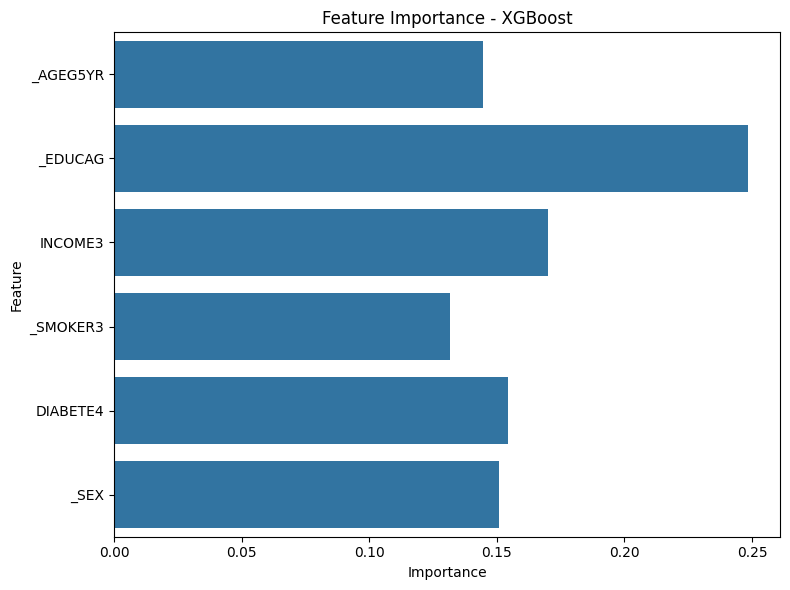

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(
    x=model.feature_importances_,
    y=X.columns
)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [10]:
# Install CatBoost
!pip install catboost

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# CatBoost
cat_model = CatBoostClassifier(verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_proba = cat_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score

print("CatBoost Accuracy:", accuracy_score(y_test, cat_pred))
print("CatBoost AUC:", roc_auc_score(y_test, cat_proba))

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest AUC:", roc_auc_score(y_test, rf_proba))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
CatBoost Accuracy: 0.7205240174672489
CatBoost AUC: 0.665934913268521
Random Forest Accuracy: 0.6908296943231441
Random Forest AUC: 0.6191616772209867


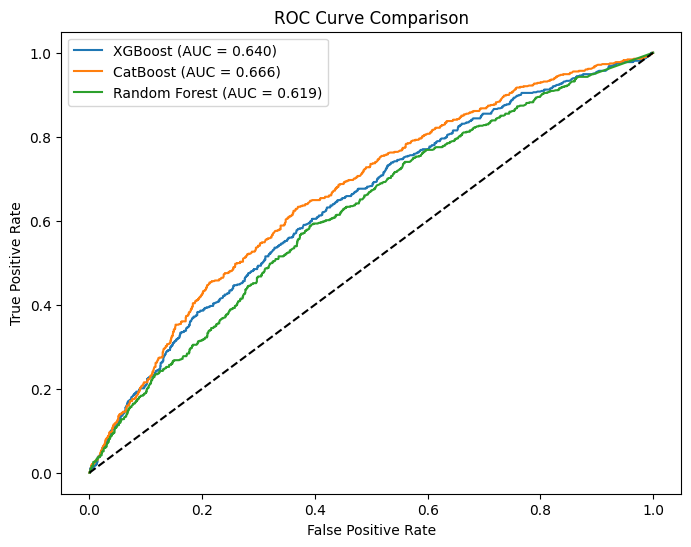

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

# XGBoost ROC
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc(fpr, tpr):.3f})')

# CatBoost ROC
fpr, tpr, _ = roc_curve(y_test, cat_proba)
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc_score(y_test, cat_proba):.3f})')

# Random Forest ROC
fpr, tpr, _ = roc_curve(y_test, rf_proba)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_proba):.3f})')

plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


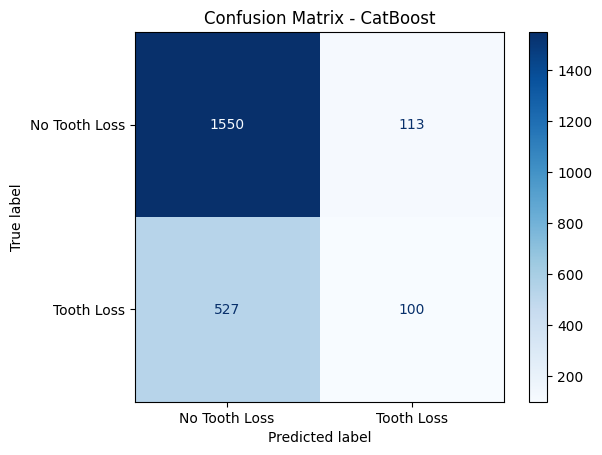

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap

# Confusion matrix for CatBoost (you can replace cat_pred with any model predictions)
cm = confusion_matrix(y_test, cat_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tooth Loss', 'Tooth Loss'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CatBoost')
plt.show()


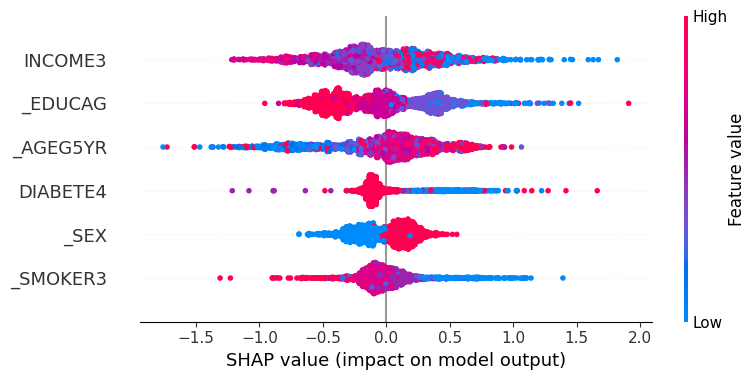

In [13]:
# Install shap
!pip install shap

import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)


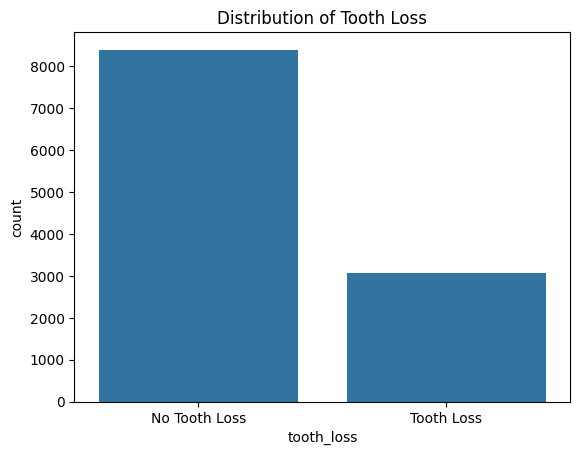

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='tooth_loss', data=data)
plt.xticks([0,1], ['No Tooth Loss', 'Tooth Loss'])
plt.title('Distribution of Tooth Loss')
plt.show()


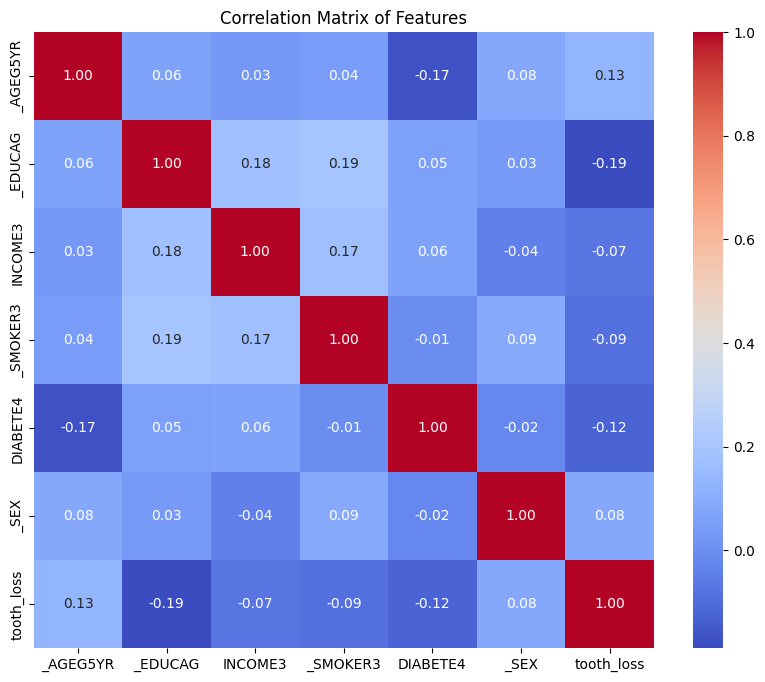

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


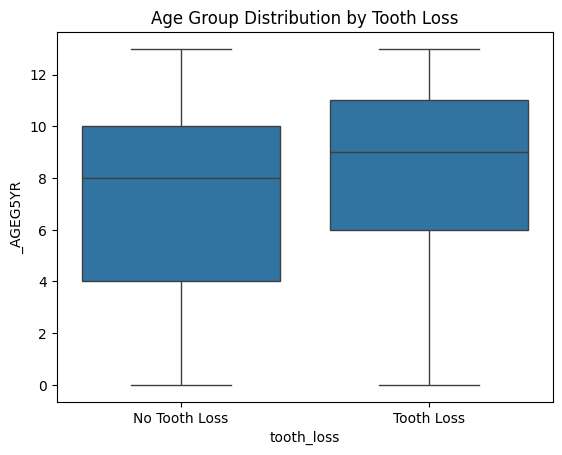

In [16]:
sns.boxplot(x='tooth_loss', y='_AGEG5YR', data=data)
plt.xticks([0,1], ['No Tooth Loss', 'Tooth Loss'])
plt.title('Age Group Distribution by Tooth Loss')
plt.show()

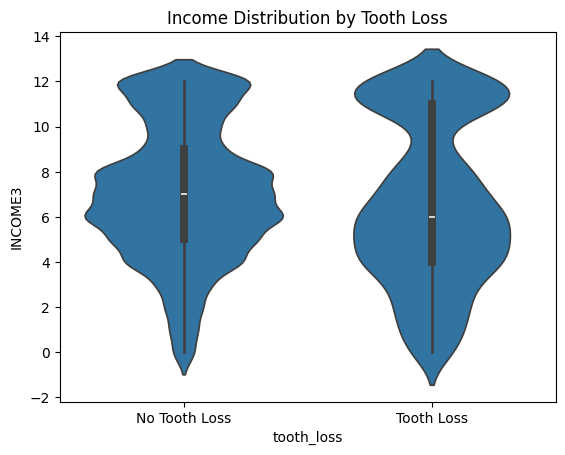

In [17]:
sns.violinplot(x='tooth_loss', y='INCOME3', data=data)
plt.xticks([0,1], ['No Tooth Loss', 'Tooth Loss'])
plt.title('Income Distribution by Tooth Loss')
plt.show()


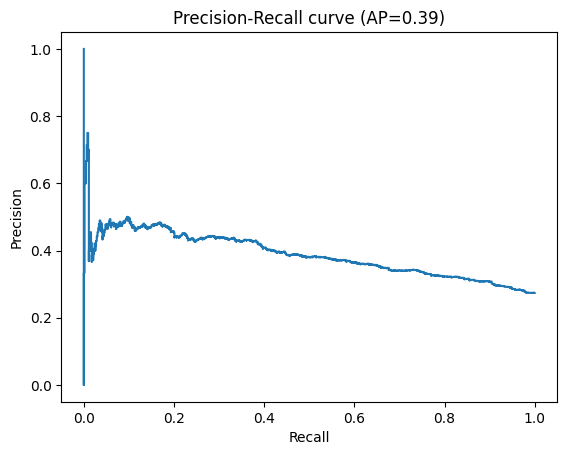

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
avg_precision = average_precision_score(y_test, model.predict_proba(X_test)[:,1])

plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP={avg_precision:.2f})')
plt.show()


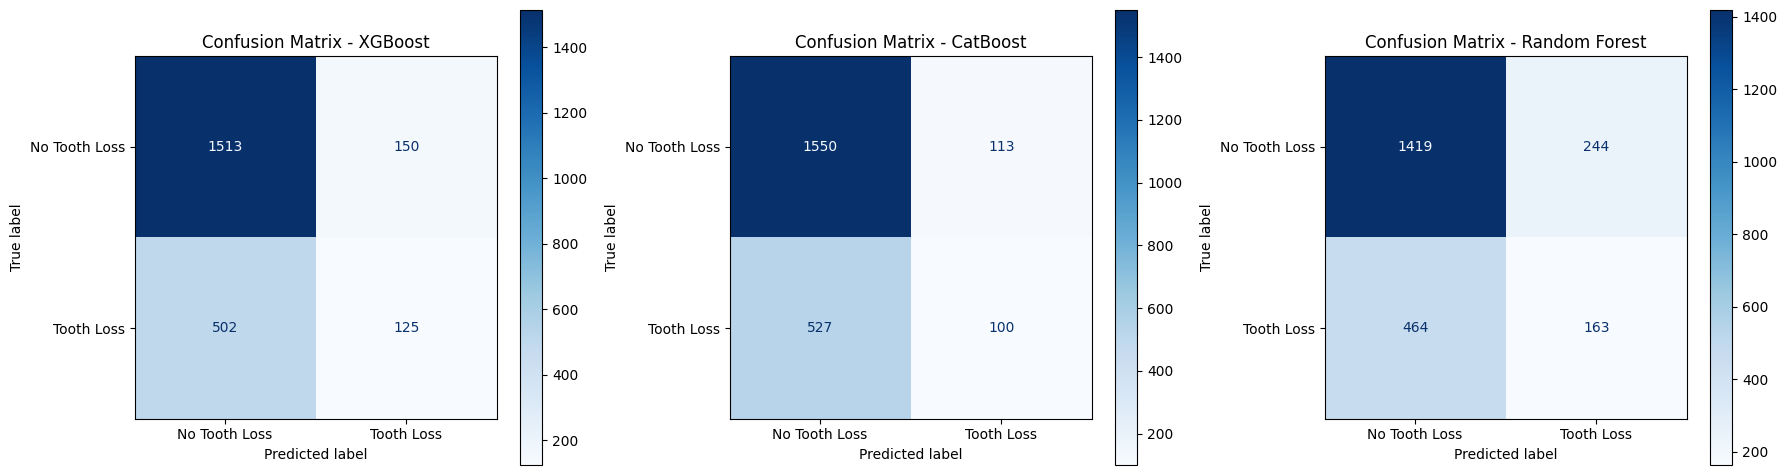

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for ax, model_name, preds in zip(axes,
                                ['XGBoost', 'CatBoost', 'Random Forest'],
                                [y_pred, cat_pred, rf_pred]):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tooth Loss', 'Tooth Loss'])
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix - {model_name}')
plt.tight_layout()
plt.show()


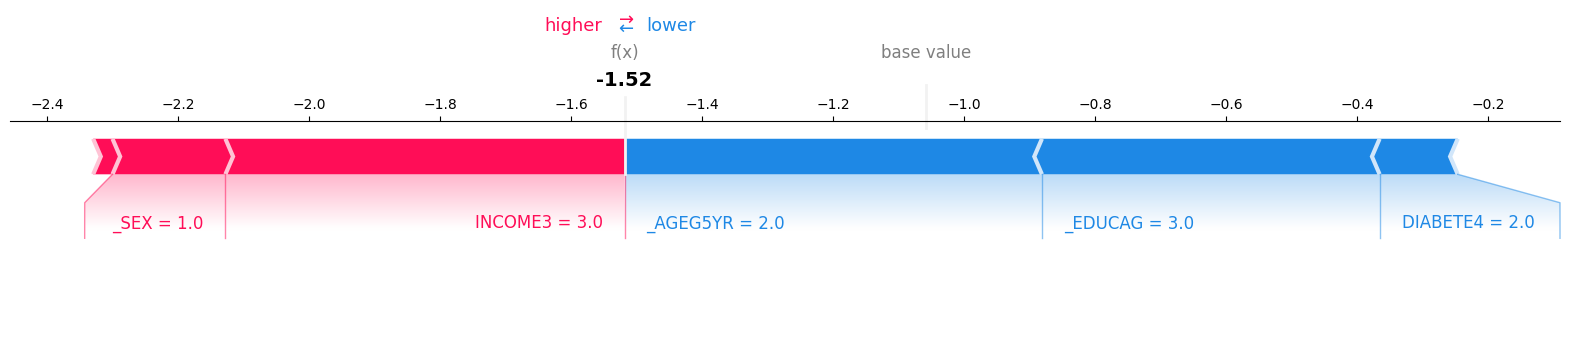

In [20]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Pick one instance (index 0) Explanation object
instance_shap = shap_values[0]

# Use shap.force_plot with the Explanation object
shap.force_plot(explainer.expected_value, instance_shap.values, X_test.iloc[0,:], matplotlib=True)



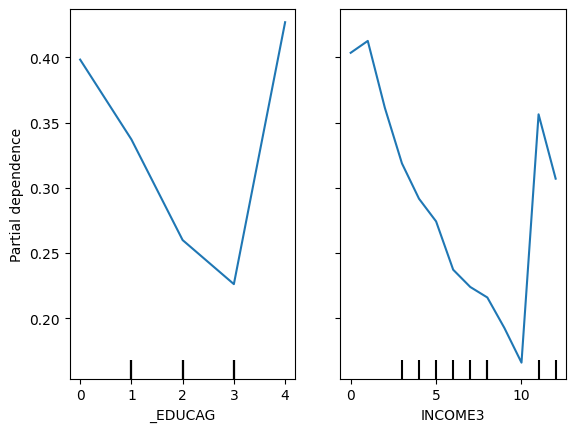

In [21]:
# Partial dependence plot example
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(model, X_test, ['_EDUCAG', 'INCOME3'], grid_resolution=20)
plt.show()

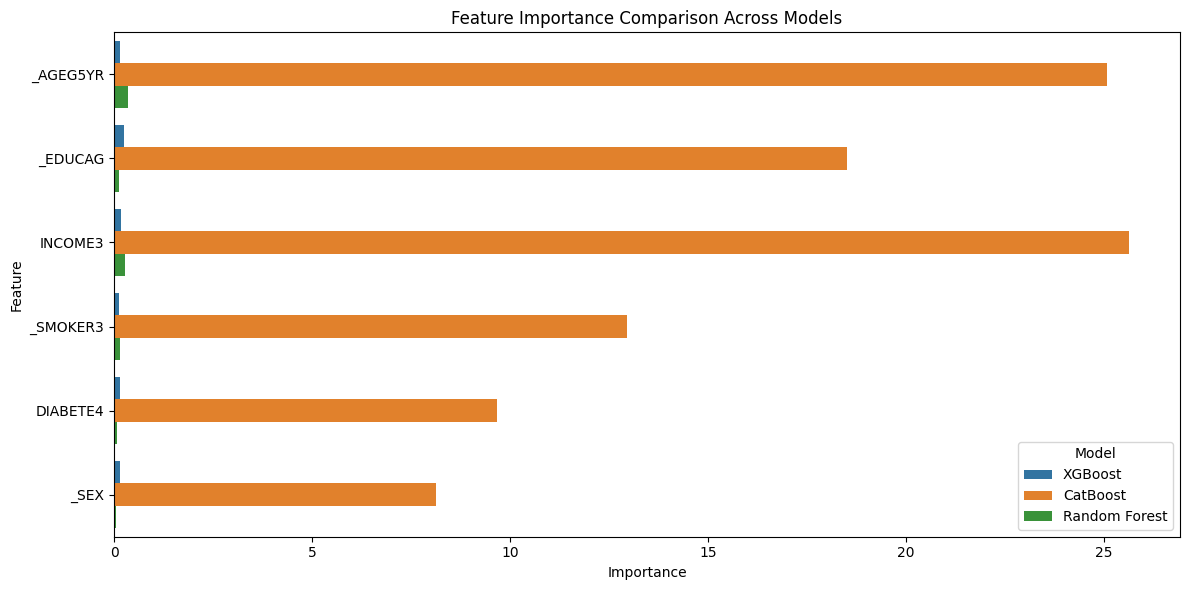

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from each model
xgb_importances = model.feature_importances_
cat_importances = cat_model.get_feature_importance()
rf_importances = rf_model.feature_importances_

features = X.columns

# Create DataFrame for plotting
fi_df = pd.DataFrame({
    'Feature': features,
    'XGBoost': xgb_importances,
    'CatBoost': cat_importances,
    'Random Forest': rf_importances
})

fi_df = fi_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')

import seaborn as sns
plt.figure(figsize=(12,6))
sns.barplot(data=fi_df, x='Importance', y='Feature', hue='Model')
plt.title('Feature Importance Comparison Across Models')
plt.tight_layout()
plt.show()


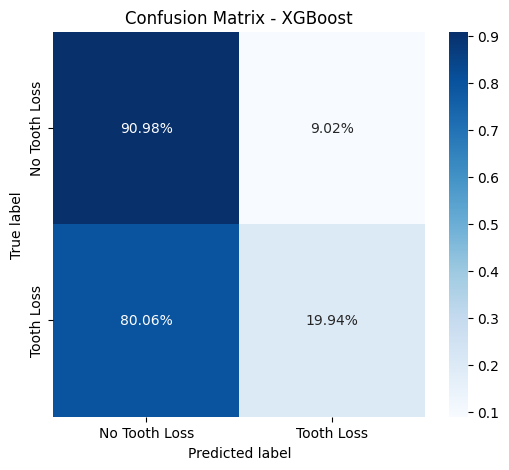

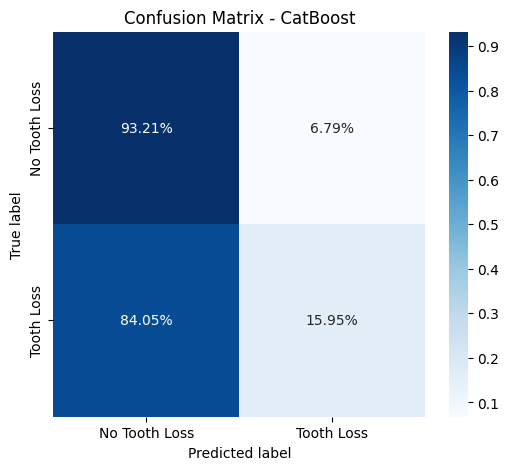

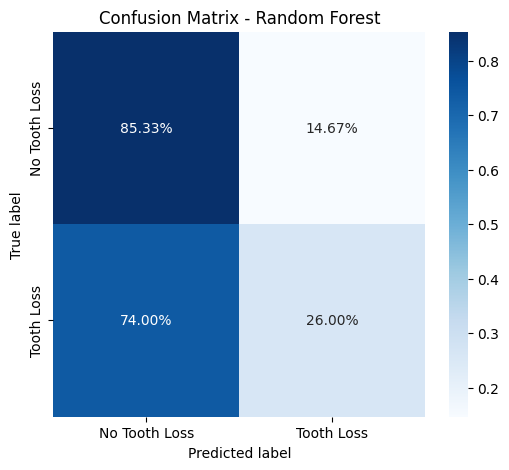

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix_heatmap(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap='Blues', xticklabels=['No Tooth Loss', 'Tooth Loss'], yticklabels=['No Tooth Loss', 'Tooth Loss'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

plot_confusion_matrix_heatmap(y_test, y_pred, 'Confusion Matrix - XGBoost')
plot_confusion_matrix_heatmap(y_test, cat_pred, 'Confusion Matrix - CatBoost')
plot_confusion_matrix_heatmap(y_test, rf_pred, 'Confusion Matrix - Random Forest')


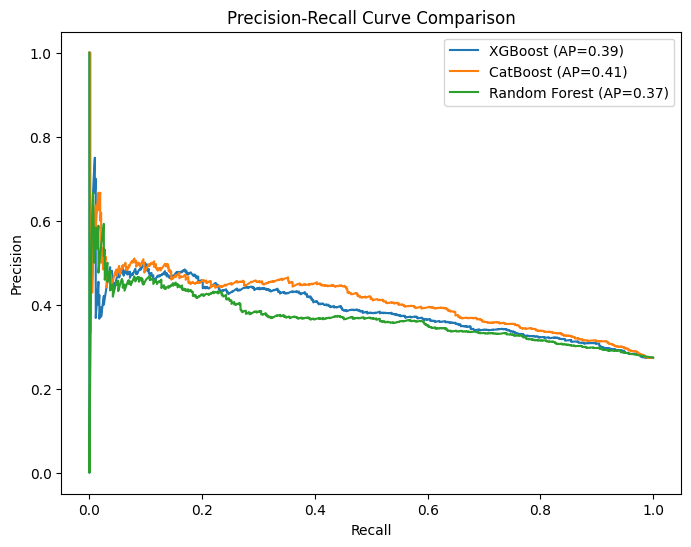

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))

for y_prob, name in zip([model.predict_proba(X_test)[:,1], cat_proba, rf_proba], ['XGBoost', 'CatBoost', 'Random Forest']):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap_score = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f"{name} (AP={ap_score:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()


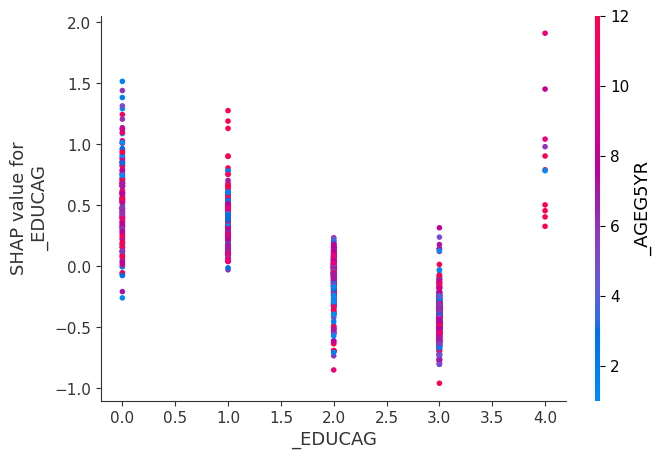

In [25]:
shap.dependence_plot('_EDUCAG', shap_values.values, X_test, interaction_index='_AGEG5YR')


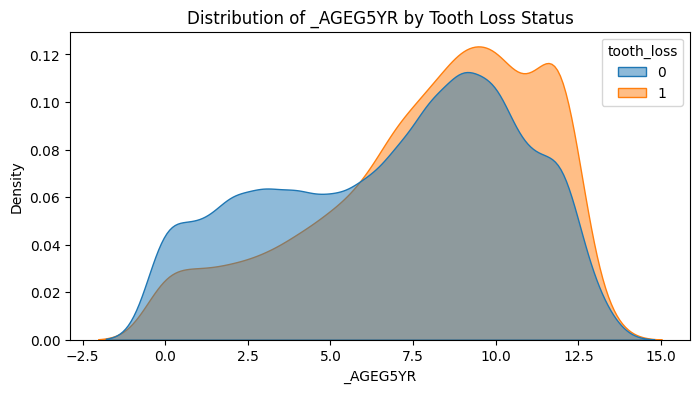

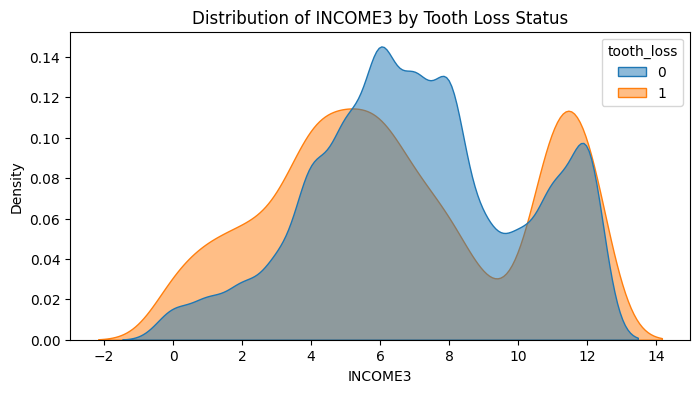

In [26]:
for feature in ['_AGEG5YR', 'INCOME3']:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=data, x=feature, hue='tooth_loss', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Distribution of {feature} by Tooth Loss Status')
    plt.show()


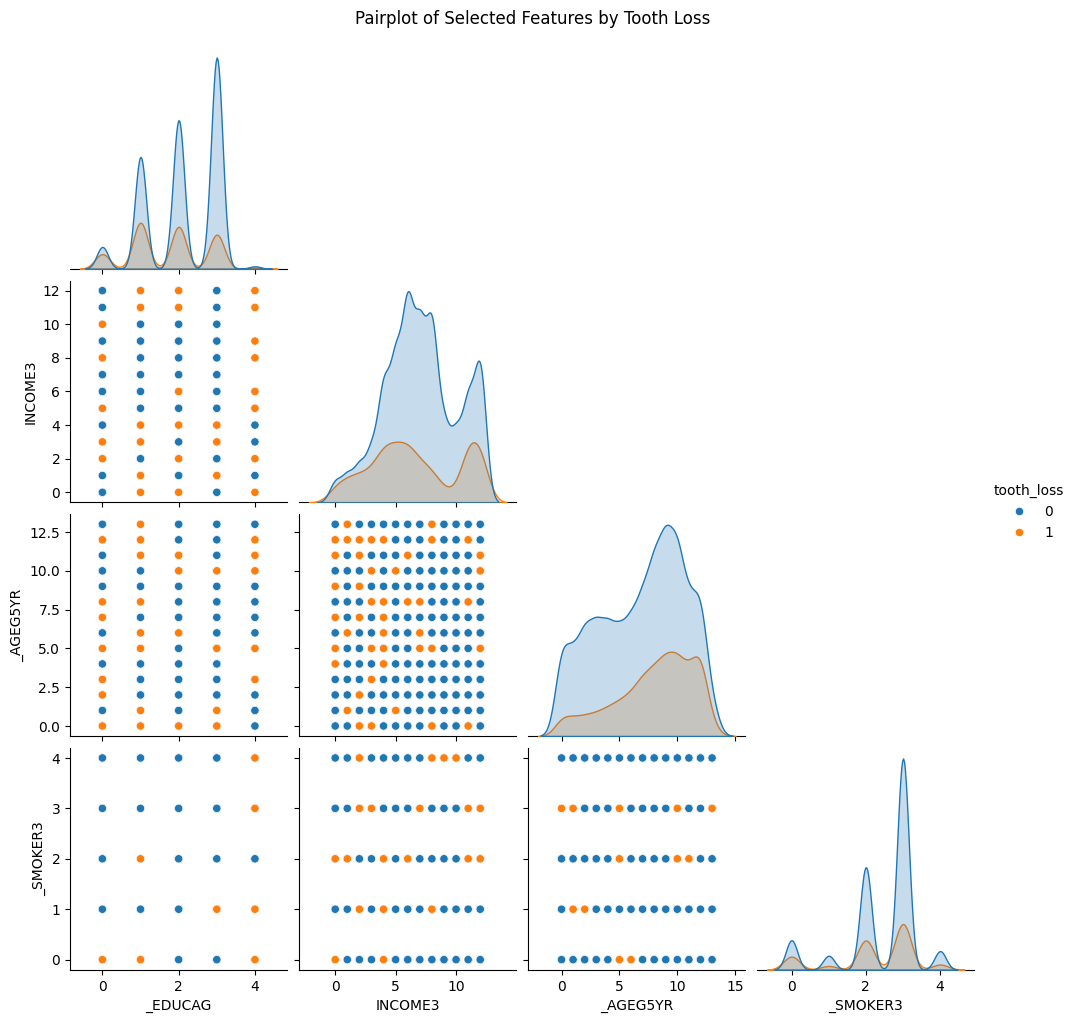

In [27]:
sns.pairplot(data[['tooth_loss', '_EDUCAG', 'INCOME3', '_AGEG5YR', '_SMOKER3']], hue='tooth_loss', corner=True)
plt.suptitle('Pairplot of Selected Features by Tooth Loss', y=1.02)
plt.show()


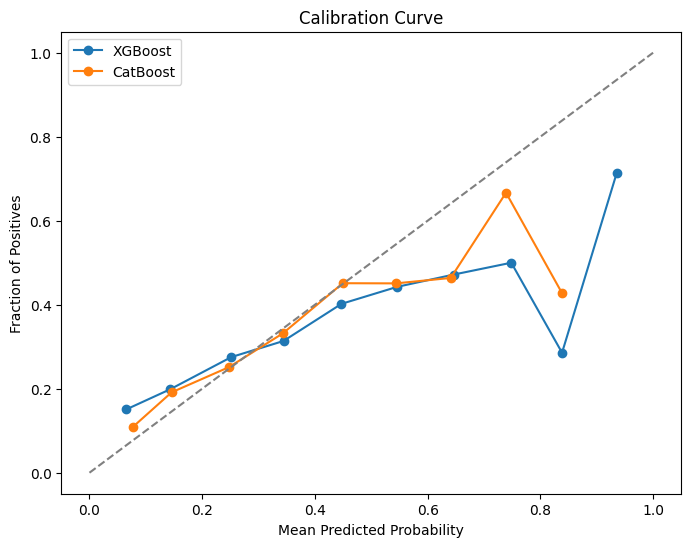

In [28]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8,6))
for y_prob, name in zip([model.predict_proba(X_test)[:,1], cat_proba], ['XGBoost', 'CatBoost']):
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()


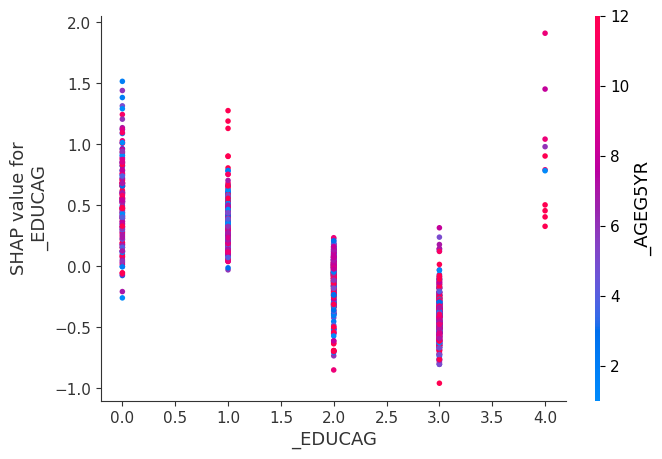

In [29]:
# 3️⃣ SHAP Dependence Plot: Education vs Age Group Interaction

import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot how EDUCAG affects prediction and interacts with AGEG5YR
shap.dependence_plot('_EDUCAG', shap_values.values, X_test, interaction_index='_AGEG5YR')


In [30]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)


In [33]:
from sklearn.metrics import classification_report

print("Random Forest Report:\n", classification_report(y_test, rf_pred))
print("KNN Report:\n", classification_report(y_test, knn_pred))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.74      0.67      0.71      1718
           1       0.69      0.76      0.72      1638

    accuracy                           0.71      3356
   macro avg       0.72      0.71      0.71      3356
weighted avg       0.72      0.71      0.71      3356

KNN Report:
               precision    recall  f1-score   support

           0       0.71      0.61      0.66      1718
           1       0.65      0.74      0.69      1638

    accuracy                           0.68      3356
   macro avg       0.68      0.68      0.68      3356
weighted avg       0.68      0.68      0.67      3356



In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                       param_grid, cv=3, scoring='recall')
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best recall score:", grid_rf.best_score_)


Best RF params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best recall score: 0.7178209520048702


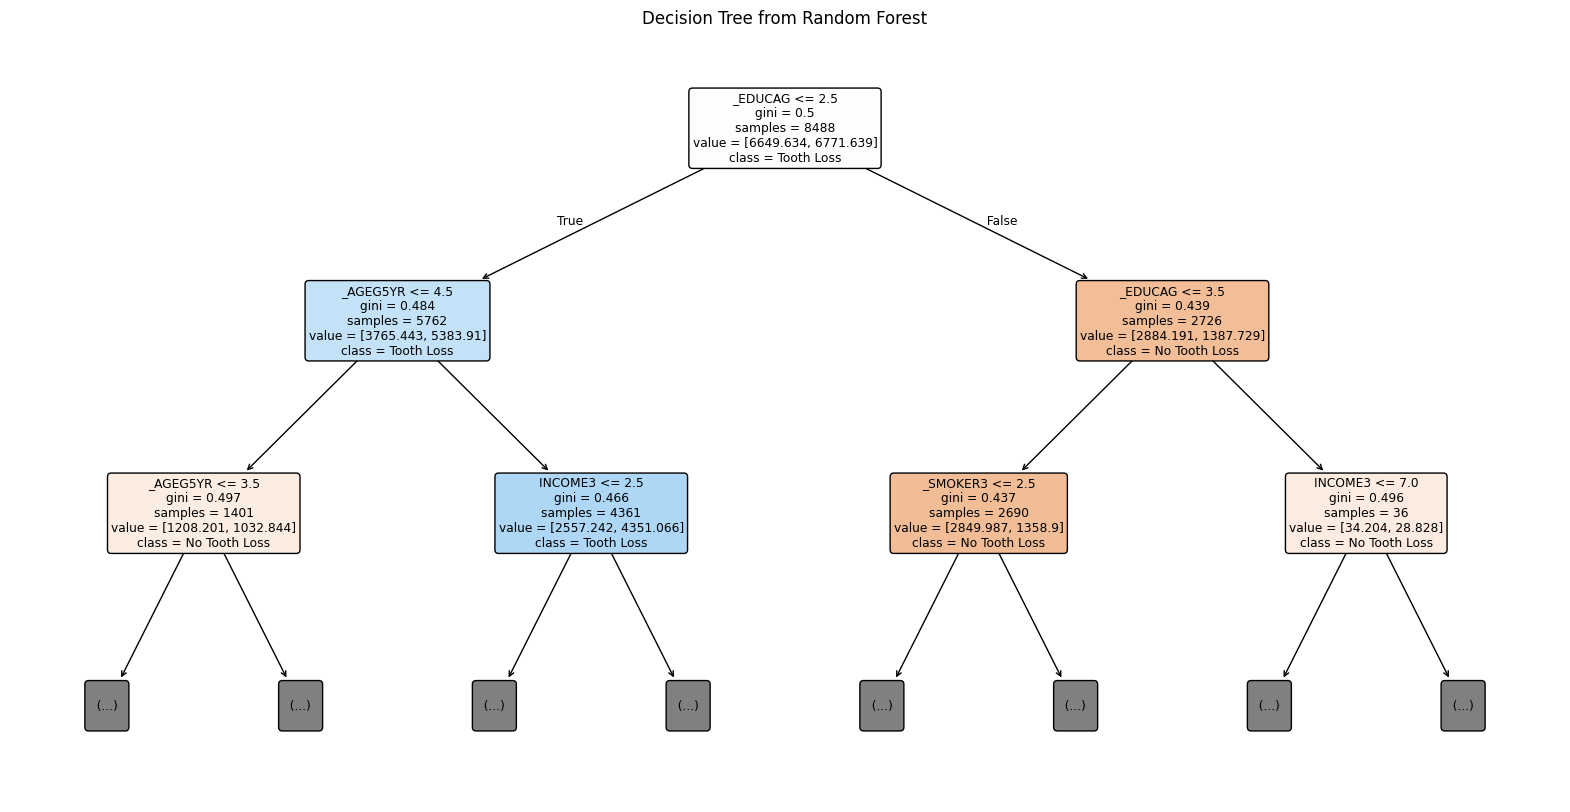

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pick the first tree in the forest
estimator = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=X.columns,
          class_names=['No Tooth Loss', 'Tooth Loss'],
          filled=True,
          rounded=True,
          max_depth=2)  # limit depth to keep it readable
plt.title("Decision Tree from Random Forest")
plt.show()
